In [6]:
import numpy as np
# from scipy.stats import gaussian_kde as kde
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")

from physicsconstants import PhysicsConstants

In [7]:
pc = PhysicsConstants()

GeV = pc.GeV
sec = pc.sec
pbarn = pc.picobarn
au = 1.496e+13 # cm
solar_angle = 6.807e-5 # steradian 

In [8]:
ms            = np.array([100, 250, 500, 1000, 3000, 5000, 10000])
chans         = ["bb", "WW", "tautau"]
ws_chans      = [5, 8, 11]
ws_chan_dict  = {chans[i]:ws_chans[i] for i in range(3)}

si_ann_rate_dict = {500   : 4.5418315143731186e+27,
                    1000  : 1.3457320571730637e+27,
                    3000  : 1.674577361367118e+26,
                    5000  : 6.160055092277992e+25,
                    10000 : 1.5644775205377196e+25
                   } # 1/sec (xs=1 pb)

sd_ann_rate_dict = {500   : 6.697084065971152e+24,
                    1000  : 1.679607455216801e+24,
                    3000  : 1.8680716988310504e+23,
                    5000  : 6.7252930524968645e+22,
                    10000 : 1.681276619465538e+22
                   } # 1/sec (xs=1 pb)

bb_sd_limit      = np.array([3.29e-03, 2.80e-03, 3.06e-03, 2.59e-03, 6.76e-03, 1.58e-02, 5.27e-02]) # picobarns
ww_sd_limit      = np.array([9.52e-05, 5.30e-05, 3.76e-05, 6.80e-05, 5.42e-04, 1.37e-03, 5.96e-03]) # picobarns
tt_sd_limit      = np.array([2.91e-05, 2.82e-05, 1.46e-05, 2.07e-05, 1.21e-04, 3.28e-04, 1.40e-03]) # picobarns
bb_sd_limit_dict = {ms[i]:bb_sd_limit[i] for i in range(len(ms))}
ww_sd_limit_dict = {ms[i]:ww_sd_limit[i] for i in range(len(ms))}
tt_sd_limit_dict = {ms[i]:tt_sd_limit[i] for i in range(len(ms))}
sd_limit_dict    = {"bb":bb_sd_limit_dict, "WW":ww_sd_limit_dict, "tautau":tt_sd_limit_dict}

bb_si_limit = np.array([7.38e-06, 3.50e-06, 2.82e-06, 2.00e-06, 4.65e-06, 1.06e-05, 3.46e-05]) # picobarns
ww_si_limit = np.array([2.13e-07, 6.62e-08, 3.49e-08, 5.28e-08, 3.70e-07, 9.14e-07, 3.88e-06]) # picobarns
tt_si_limit = np.array([6.48e-08, 3.52e-08, 1.35e-08, 1.60e-08, 8.25e-08, 2.19e-07, 9.11e-07]) # picobarns
bb_si_limit_dict = {ms[i]:bb_si_limit[i] for i in range(len(ms))}
ww_si_limit_dict = {ms[i]:ww_si_limit[i] for i in range(len(ms))}
tt_si_limit_dict = {ms[i]:tt_si_limit[i] for i in range(len(ms))}
si_limit_dict    = {"bb":bb_si_limit_dict, "WW":ww_si_limit_dict, "tautau":tt_si_limit_dict}
xs_limit_dict = {}
xs_limit_dict["si"] = si_limit_dict
xs_limit_dict["sd"] = sd_limit_dict

In [9]:
zens  = np.linspace(80, 180, 101)
e_min = 1

In [5]:
# flux = np.load(" /ch8_m1000_flux.npy")
# nu_flux     = flux[0]
# nu_bar_flux = flux[1]
# n_zen       = nu_flux.shape[0]
# n_en        = nu_flux.shape[1]
# es          = np.tile(np.linspace(e_min, 1000, n_en), n_zen)
# zs          = np.concatenate([np.full(n_en, zen) for zen in zens])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jlazar/Documents/IceCube/data/ch8_m1000_flux.npy'

In [5]:
def interp_dn_dz(ch, m):
    
    ws_ch = ws_chan_dict[ch]
    
    # Load data files
    dN_dz  = np.load("/Users/jlazar/Documents/IceCube/solar_WIMP/data/qr_dn_dz/ch%d_m%d_dn_dz.npy" % (ws_ch, m))
    mc     = np.load("/Users/jlazar/Documents/IceCube/data/mcRecarray.npy")
    
    # Get all quantities from dN_dE file arranged
    nu_flux     = dN_dz[0]
    nu_bar_flux = dN_dz[1]
    n_zen       = nu_flux.shape[0]
    n_en        = nu_flux.shape[1]
    es          = np.tile(np.linspace(e_min, m, n_en), n_zen)
    zs          = np.concatenate([np.full(n_en, zen) for zen in zens])
    
    # Get all mc quantities ready
    nu_i           = np.where(mc["i"]==14)[0]
    nu_bar_i       = np.where(mc["i"]==-14)[0]
    nu_e           = mc["nuE"][nu_i]
    nu_bar_e       = mc["nuE"][nu_bar_i]
    nu_zen         = np.degrees(mc["nuZen"][nu_i])
    nu_bar_zen     = np.degrees(mc["nuZen"][nu_bar_i])
    
    
    # Prepare points and values arrays
    points        = np.vstack([es,zs]).T
    nu_values     = np.log10(np.concatenate(nu_flux))
    nu_bar_values = np.log10(np.concatenate(nu_bar_flux))

    # Replace -infinities from log(0) with large neg values
    nu_values[np.where(np.isinf(nu_values))]         = -500
    nu_bar_values[np.where(np.isinf(nu_bar_values))] = -500
    
    # Interpolate
    nu_gd          = griddata(points, nu_values,     (nu_e, nu_zen),         method="linear")
    nu_bar_gd      = griddata(points, nu_bar_values, (nu_bar_e, nu_bar_zen), method="linear")
    nu_interp      = np.power(10, nu_gd)
    nu_bar_interp  = np.power(10, nu_bar_gd)
        
    nu_interp[np.where(nu_e>m)[0]]         = 0
    nu_bar_interp[np.where(nu_bar_e>m)[0]] = 0
    
    # Save interpolated fluxes
    mc_flux           = np.zeros(len(mc["i"]))
    mc_flux[nu_i]     = nu_interp
    mc_flux[nu_bar_i] = nu_bar_interp
    mc_flux[np.where(np.isnan(mc_flux))] = 0
    np.save("/Users/jlazar/Documents/IceCube/solar_WIMP/data/qr_dn_dz/ch%d_m%d_mc_dn_dz.npy" % (ws_ch, m), mc_flux)
    return mc_flux

In [ ]:
points = np.vstack([es,zs]).T
values = np.log10(np.concatenate(nu_flux))
values[np.where(np.isinf(values))] = -500

In [ ]:
test = griddata(points[:400], values[:400], (es, 80.), method="cubic")

In [ ]:
plt.plot(points.T[0][200:400], np.power(10, values[200:400]))
plt.plot(points.T[0][200:400], np.power(10, test[200:400]))
plt.semilogy()
plt.show()

In [48]:
flux = np.load("/Users/jlazar/Documents/IceCube/data/ch11_m3000_flux.npy")
nu_flux     = flux[0]
nu_bar_flux = flux[1]
n_zen       = nu_flux.shape[0]
n_en        = nu_flux.shape[1]
es          = np.tile(np.linspace(e_min, 3000, n_en), n_zen)
zs          = np.concatenate([np.full(n_en, zen) for zen in zens])

In [49]:
points = np.vstack([es,zs]).T
values = np.log10(np.concatenate(nu_flux))
values[np.where(np.isinf(values))] = -500

/Users/jlazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/jlazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [71]:
np.power(10, griddata(points, values, (2511.13002521, 21.68800973), method="linear"))

griddata(points, values, (2511.13002521, 21.68800973))

array(nan)

In [1]:
# def interp_flux(ch, m):
    
#     ws_ch = ws_chan_dict[ch]
    
#     # Load data files
#     dN_dE  = np.load("/Users/jlazar/Downloads/ch%d_m%d_flux.npy" % (ws_ch, m))
#     mc     = np.load("/Users/jlazar/Documents/IceCube/data/mcRecarray.npy")
    
#     # Get all quantities from dN_dE file arranged
#     flux        = dN_dE * (1./(4*np.pi*au**2)) * sd_ann_rate_dict[m] * sd_limit_dict[ch][m] / solar_angle
#     nu_flux     = flux[0]
#     nu_bar_flux = flux[1]
#     n_zen       = nu_flux.shape[0]
#     n_en        = nu_flux.shape[1]
#     es          = np.tile(np.linspace(e_min, m, n_en), n_zen)
#     zs          = np.concatenate([np.full(n_en, zen) for zen in zens])
    
#     # Get all mc quantities ready
#     nu_i           = np.where(mc["i"]==14)[0]
#     nu_bar_i       = np.where(mc["i"]==-14)[0]
#     nu_e           = mc["nuE"][nu_i]
#     nu_bar_e       = mc["nuE"][nu_bar_i]
#     nu_zen         = np.degrees(mc["nuZen"][nu_i])
#     nu_bar_zen     = np.degrees(mc["nuZen"][nu_bar_i])
    
    
#     # Prepare points and values arrays
#     points        = np.vstack([es,zs]).T
#     nu_values     = np.log10(np.concatenate(nu_flux))
#     nu_bar_values = np.log10(np.concatenate(nu_bar_flux))

#     # Replace -infinities from log(0) with large neg values
#     nu_values[np.where(np.isinf(nu_values))]         = -500
#     nu_bar_values[np.where(np.isinf(nu_bar_values))] = -500
    
#     # Interpolate
#     nu_gd          = griddata(points, nu_values,     (nu_e, nu_zen),         method="linear")
#     nu_bar_gd      = griddata(points, nu_bar_values, (nu_bar_e, nu_bar_zen), method="linear")
#     nu_interp      = np.power(10, nu_gd)
#     nu_bar_interp  = np.power(10, nu_bar_gd)
        
#     nu_interp[np.where(nu_e>m)[0]]         = 0
#     nu_bar_interp[np.where(nu_bar_e>m)[0]] = 0
    
#     # Save interpolated fluxes
#     mc_flux           = np.zeros(len(mc["i"]))
#     mc_flux[nu_i]     = nu_interp
#     mc_flux[nu_bar_i] = nu_bar_interp
#     mc_flux[np.where(np.isnan(mc_flux))] = 0
#     np.save("/Users/jlazar/Documents/IceCube/data/ch%d_m%d_mc_flux.npy" % (ws_ch, m), mc_flux)
#     return mc_flux

In [2]:
# plz = interp_flux("tautau", 3000)

In [3]:
# for m in ms[2:]:
#     for ch in chans:
#         interp_flux(ch, m)

In [4]:
# plt.plot(np.linspace(0,1,200), np.load("/Users/jlazar/Documents/IceCube/data/ch8_m1000_flux.npy")[0][0])
# plt.semilogy()
# plt.xlabel(r"$x=\frac{E_{\nu}}{m_{\chi}}$")
# plt.ylabel(r"$\frac{dN_{\oplus}}{dx}$")
# plt.grid(which="both")
# plt.title(r"$\chi\chi\rightarrow W^{+}W^{-}, m_{\chi}=1000$ GeV")
# plt.show()

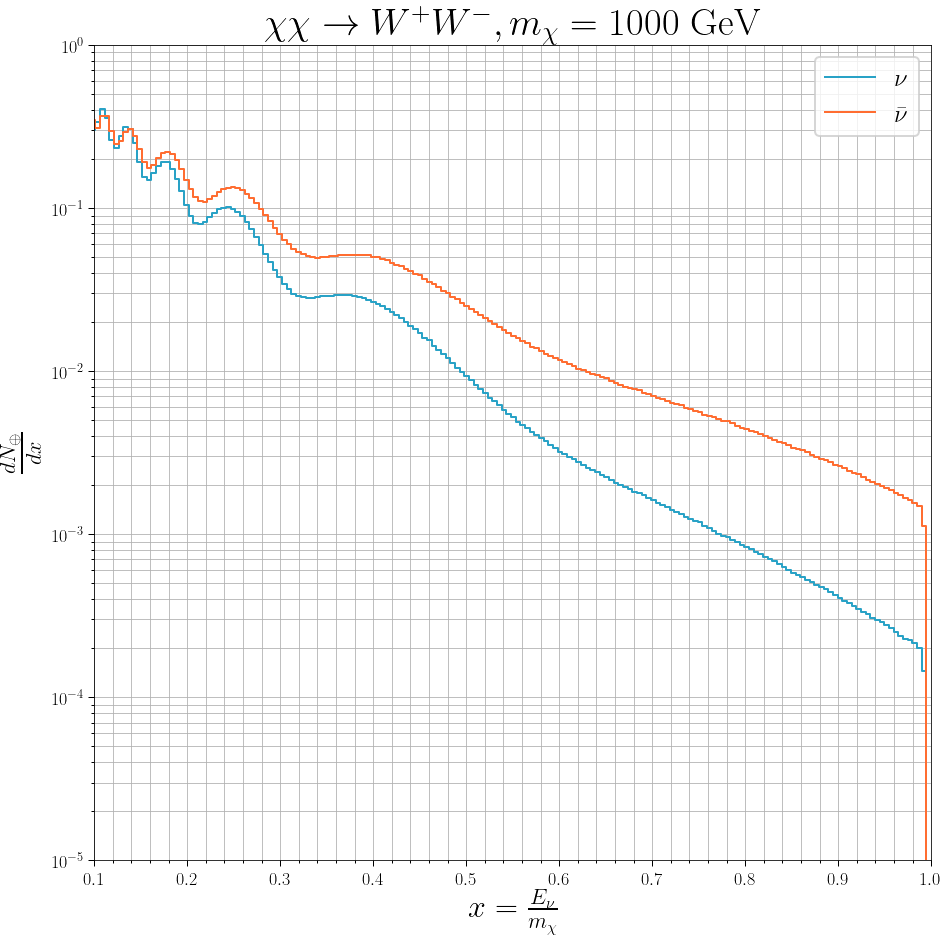

In [37]:
f = np.load("ch8_m1000_test.npy")*1000
plt.step(np.linspace(0.001,1,200), f[0],label=r"$\nu$")
plt.step(np.linspace(0.001,1,200), f[1],label=r"$\bar{\nu}$")
plt.semilogy()
plt.xlabel(r"$x=\frac{E_{\nu}}{m_{\chi}}$")
plt.ylabel(r"$\frac{dN_{\oplus}}{dx}$")
plt.grid(which="both")
plt.legend()
plt.ylim(1e-5,1)
plt.xlim(0.1,1)
plt.title(r"$\chi\chi\rightarrow W^{+}W^{-}, m_{\chi}=1000$ GeV")
plt.show()

## bb check

In [ ]:
np.load()